# **COMP9517 - Group Project (Segmentation Models Pytorch)**

## **0. Add Imports**

In [1]:
# !conda env create -f environment.yaml

In [ ]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, RichModelSummary, StochasticWeightAveraging, Timer
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

from data import AerialDeadTreeSegDataModule, download_dataset
from lightning.pytorch.tuner import Tuner
from lightning_modules import SMPLitModule
from models import FreezeSMPEncoderUtils
from utils import paths
import segmentation_models_pytorch as smp


In [3]:
ARCH = "UNet"
ENCODER_NAME = "resnet50"
VERSION = "swa_test"
TARGET_SIZE = 256
BATCH_SIZE = 32
MAX_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 15
LOSS1 = smp.losses.JaccardLoss(mode='binary', from_logits=True)
LOSS2 = smp.losses.FocalLoss(mode='binary')

## **1. Simple Summary of the Dattaset**

In [4]:
from PIL import Image
# Get the data folder
data_folder = download_dataset()

rgb_dir = os.path.join(data_folder, "RGB_images")
nrg_dir = os.path.join(data_folder, "NRG_images")
mask_dir = os.path.join(data_folder, "masks")

# Get the max and min resolution of the images
def get_max_min_resolution(image_dir):
    max_res = (0, 0)
    min_res = (float('inf'), float('inf'))
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            filepath = os.path.join(image_dir, filename)
            with open(filepath, 'rb') as f:
                img = Image.open(f)
                height, width = img.size
                max_res = (max(max_res[0], height), max(max_res[1], width))
                min_res = (min(min_res[0], height), min(min_res[1], width))
    return max_res, min_res
max_rgb_res, min_rgb_res = get_max_min_resolution(rgb_dir)
max_nrg_res, min_nrg_res = get_max_min_resolution(nrg_dir)
print(f"Max RGB resolution: {max_rgb_res}, Min RGB resolution: {min_rgb_res}")
print(f"Max NRG resolution: {max_nrg_res}, Min NRG resolution: {min_nrg_res}")

Max RGB resolution: (652, 636), Min RGB resolution: (317, 294)
Max NRG resolution: (652, 636), Min NRG resolution: (317, 294)


## **2. Prepare Data Module**

In [5]:
data_module = AerialDeadTreeSegDataModule(
    val_split=0.1, test_split=0.2, seed=42,
    modality="merged", # in_channels=4. If modality is "merged", it will use 4 channels (RGB + NIR); Otherwise, it will use 3 channels (RGB).
    batch_size=BATCH_SIZE,
    num_workers= int(os.cpu_count() / 2) if os.cpu_count() is not None else 0,
    target_size=TARGET_SIZE)

## **3. Create Segmentation Models**

In [6]:
model = SMPLitModule(
    arch=ARCH,
    encoder_name=ENCODER_NAME,
    encoder_weights="imagenet",
    in_channels=data_module.in_channels,
    out_classes=1,  # Binary segmentation
    loss1=LOSS1,
    loss2=LOSS2,
)

## **4. Create Trainer**

In [ ]:
model_sum_callback = RichModelSummary(max_depth=2)

lr_monitor = LearningRateMonitor(logging_interval='step')

early_stop_callback = EarlyStopping(
    monitor="per_image_iou/val",
    patience=EARLY_STOPPING_PATIENCE,
    verbose=True,
    mode="max"  # Maximize the metric
)

timer = Timer(interval="epoch", verbose=False)
                
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(paths.checkpoint_dir, f"smp_{ENCODER_NAME}_{ARCH}", VERSION),
    monitor="per_image_iou/val",
    filename="{epoch:02d}-{per_image_iou_val:.4f}",
    mode="max",
    save_top_k=3,
    enable_version_counter=True,
)

In [ ]:
logger = TensorBoardLogger(paths.tensorboard_log_dir, name=f"smp_{ENCODER_NAME}_{ARCH}", version=VERSION)
trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    enable_progress_bar=True,
    logger=logger,
    callbacks=[
        model_sum_callback,
        lr_monitor,
        early_stop_callback,
        timer,
        checkpoint_callback
    ],
    log_every_n_steps=5,
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## **5. Find Suggested Learning Rate**

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Using existing split: ./data_splits/data_split_42_70_10.csv

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at /home/leo/unsw/comp9517/CV9517_Group-Project/notebooks/.lr_find_f66c934f-a097-4a01-b554-4ed22806d2f6.ckpt
Restored all states from the checkpoint at /home/leo/unsw/comp9517/CV9517_Group-Project/notebooks/.lr_find_f66c934f-a097-4a01-b554-4ed22806d2f6.ckpt


Teardown called, cleaning up datasets...

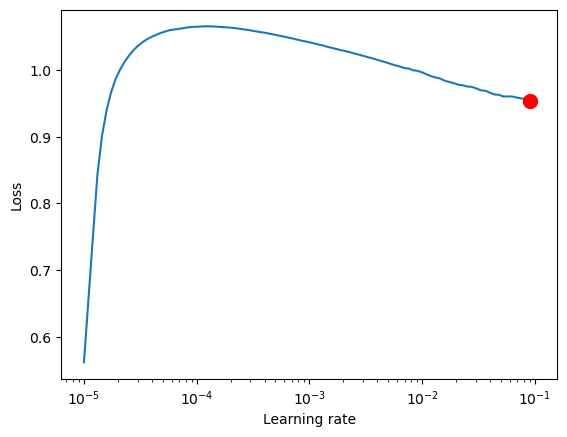

/tmp/ipykernel_2165021/1558274056.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [9]:
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, datamodule=data_module,
                          min_lr=1e-5, max_lr= 0.1,
                          num_training=100, early_stop_threshold=4)
fig = lr_finder.plot(suggest=True, show=True)
fig.show()

In [10]:
import math
suggested_lr = lr_finder.suggestion()
print(f"Original suggested learning rate: {suggested_lr}")

# Round the suggested learning rate to 1 significant digit
magnitude =  10 ** (math.floor(math.log10(suggested_lr)))
suggested_lr = round(suggested_lr / magnitude) * magnitude

print(f"Rounded suggested learning rate: {suggested_lr}")

Original suggested learning rate: 0.09120108393559097
Rounded suggested learning rate: 0.09


In [11]:
swa_callback = StochasticWeightAveraging(swa_lrs=suggested_lr, swa_epoch_start=0.6, annealing_epochs=15)
trainer.callbacks.append(swa_callback)

## **6. Train and Test Segmentation Model**

In [12]:
trainer.fit(model, datamodule=data_module)
print("Training starting time: ", timer.start_time("train"))
print("Time elapsed: ", timer.time_elapsed("train"))

Using existing split: ./data_splits/data_split_42_70_10.csv

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                    ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                   │ Unet             │ 32.5 M │ train │
│ 1 │ model.encoder           │ ResNetEncoder    │ 23.5 M │ train │
│ 2 │ model.decoder           │ UnetDecoder      │  9.0 M │ train │
│ 3 │ model.segmentation_head │ SegmentationHead │    145 │ train │
│ 4 │ loss_fn1                │ JaccardLoss      │      0 │ train │
│ 5 │ loss_fn2                │ FocalLoss        │      0 │ train │
│ 6 │ _default_loss           │ DiceLoss         │      0 │ train │
└───┴─────────────────────────┴──────────────────┴────────┴───────┘

Trainable params: 32.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 32.5 M                                                                                               
Total estimated model params size (MB): 130                                                                        
Modules in train mode: 226                                                                                         
Modules in eval mode: 0

Output()

Metric per_image_iou/val improved. New best score: 0.023


Metric per_image_iou/val improved by 0.008 >= min_delta = 0.0. New best score: 0.030


Metric per_image_iou/val improved by 0.024 >= min_delta = 0.0. New best score: 0.055


Metric per_image_iou/val improved by 0.070 >= min_delta = 0.0. New best score: 0.125


Metric per_image_iou/val improved by 0.108 >= min_delta = 0.0. New best score: 0.233


Metric per_image_iou/val improved by 0.083 >= min_delta = 0.0. New best score: 0.316


Metric per_image_iou/val improved by 0.020 >= min_delta = 0.0. New best score: 0.336


Metric per_image_iou/val improved by 0.001 >= min_delta = 0.0. New best score: 0.337


Metric per_image_iou/val improved by 0.008 >= min_delta = 0.0. New best score: 0.345


Metric per_image_iou/val improved by 0.033 >= min_delta = 0.0. New best score: 0.377


Metric per_image_iou/val improved by 0.006 >= min_delta = 0.0. New best score: 0.383


Metric per_image_iou/val improved by 0.002 >= min_delta = 0.0. New best score: 0.385


Metric per_image_iou/val improved by 0.009 >= min_delta = 0.0. New best score: 0.394


Metric per_image_iou/val improved by 0.005 >= min_delta = 0.0. New best score: 0.399


/home/leo/apps/miniconda3/envs/CVers/lib/python3.11/site-packages/lightning/pytorch/callbacks/stochastic_weight_avg
.py:225: SWA is currently only supported every epoch. Found 
LRSchedulerConfig(scheduler=<torch.optim.lr_scheduler.OneCycleLR object at 0x7003be257ed0>, name=None, 
interval='step', frequency=1, reduce_on_plateau=False, monitor=None, strict=True)

Swapping scheduler `OneCycleLR` for `SWALR`


Metric per_image_iou/val improved by 0.014 >= min_delta = 0.0. New best score: 0.412


Monitored metric per_image_iou/val did not improve in the last 15 records. Best score: 0.412. Signaling Trainer to stop.


Teardown called, cleaning up datasets...

Training starting time:  119708.557669162
Time elapsed:  418.4929310520092


In [13]:
trainer.test(model, datamodule=data_module)
print("Time elapsed: ", timer.time_elapsed("test"))

Using existing split: ./data_splits/data_split_42_70_10.csv

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       accuracy/test       │    0.9795205593109131     │
│     dataset_iou/test      │    0.3784315884113312     │
│    per_image_iou/test     │    0.38920101523399353    │
└───────────────────────────┴───────────────────────────┘

Teardown called, cleaning up datasets...

Time elapsed:  1.8275379029946635
